# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

# TODO: fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    

X_train, y_train  = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(y_train)


# TODO: number of testing examples
n_test = len(y_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)

print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)



Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


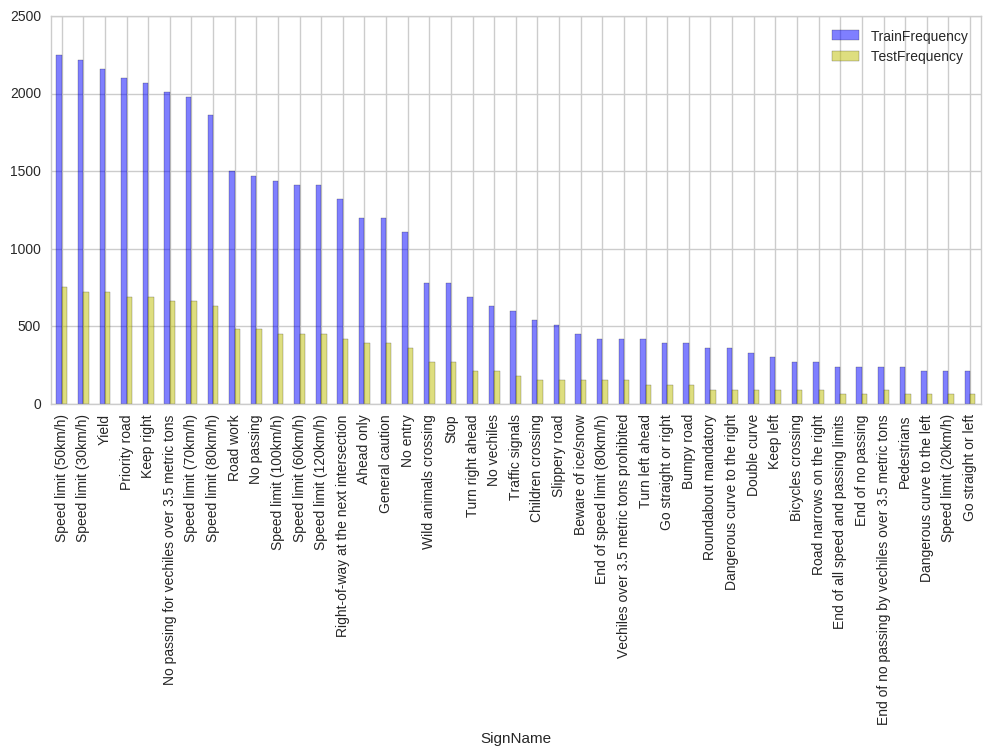

In [3]:
# Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

#load the the Sign Names
signnames = pd.read_csv("signnames.csv")

# Build dataframe for training data
traindata = pd.DataFrame(y_train, columns=["ClassId"])
traindata = traindata.merge(signnames, how="left", left_on="ClassId", right_on="ClassId")
traindata = traindata.rename(columns={'ClassId': 'TrainFrequency'})
# Build dataframe for testing data
testdata = pd.DataFrame(y_test, columns=["ClassId"])
testdata = testdata.merge(signnames, how="left", left_on="ClassId", right_on="ClassId")
testdata["TestFrequency"] = 1

# Groupby for Test summary
datacount = traindata.groupby(["SignName"]).count()
datacount = datacount.join(testdata.groupby(["SignName"])["TestFrequency"].count())
datacount = datacount.sort_values(by="TrainFrequency", ascending=False)
#print(datacount.index)
# Plot it
datacount.plot.bar(figsize=(12, 5), color=['b','y'], width=.5, alpha=0.5)

#ind = np.arange(43)  # the x locations for the groups
#width = 0.4       # the width of the bars
#fig, ax = plt.subplots()
#rects1 = ax.bar(ind, datacount["TrainFrequency"], width, color='r')
#rects1 = ax.bar(ind+width,datacount["TestFrequency"], width, color='y')
#plt.show





The training and testing data is proportionally distributed and I think It is useful as we can do the testing in a balanced manner.

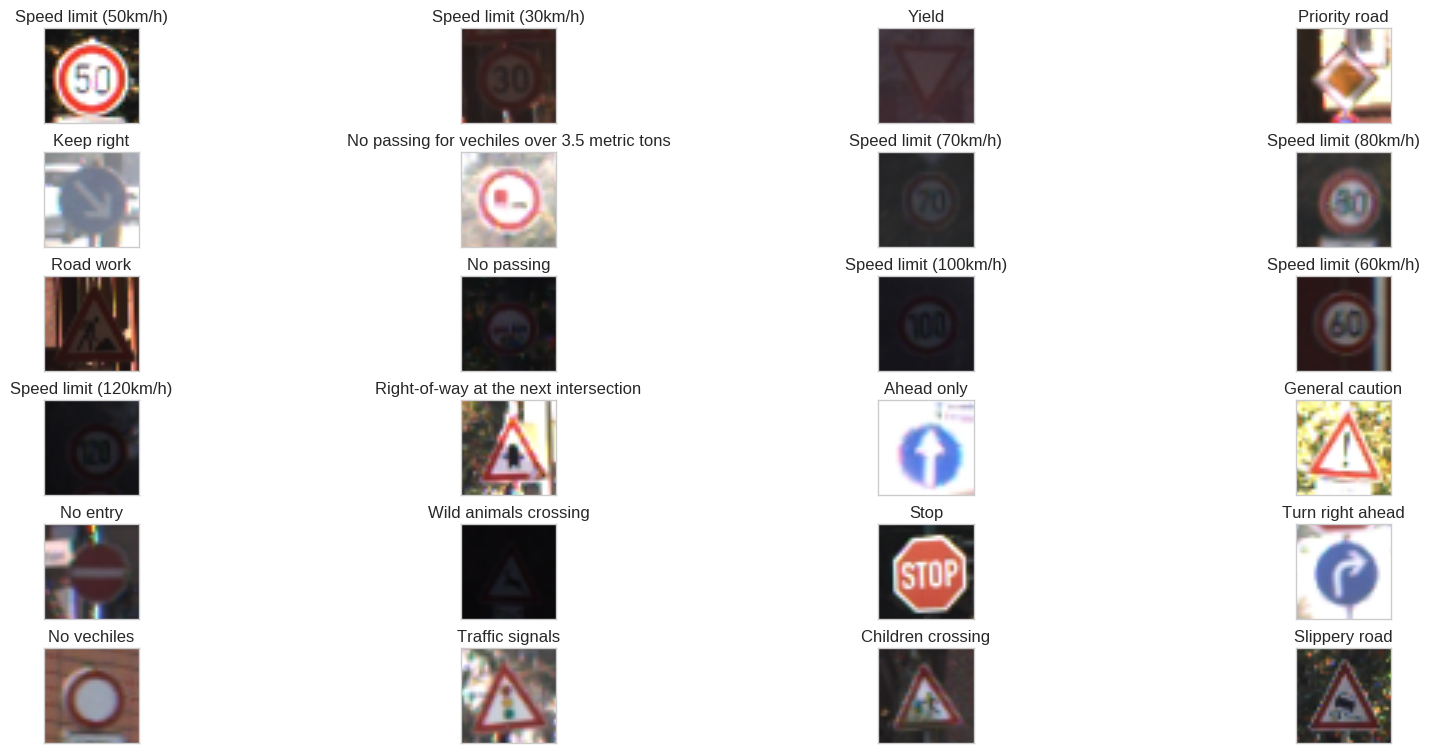

In [4]:
# I would like to view the samples in the data set

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(6, 4, top=1., bottom=-0.3, right=2., left=0., hspace=0.3, wspace=0.2)
i=0

# Get indexes of each example type we're going to visualize
for signtype in datacount.head(n=24).index:
    indexes = traindata[traindata["SignName"]==signtype].index.tolist()
    #ax=fig.add_subplot(5,3,i)
    ax=plt.subplot(gs[i])
    ax.imshow(X_train[indexes[100]])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(signtype)
    i+=1



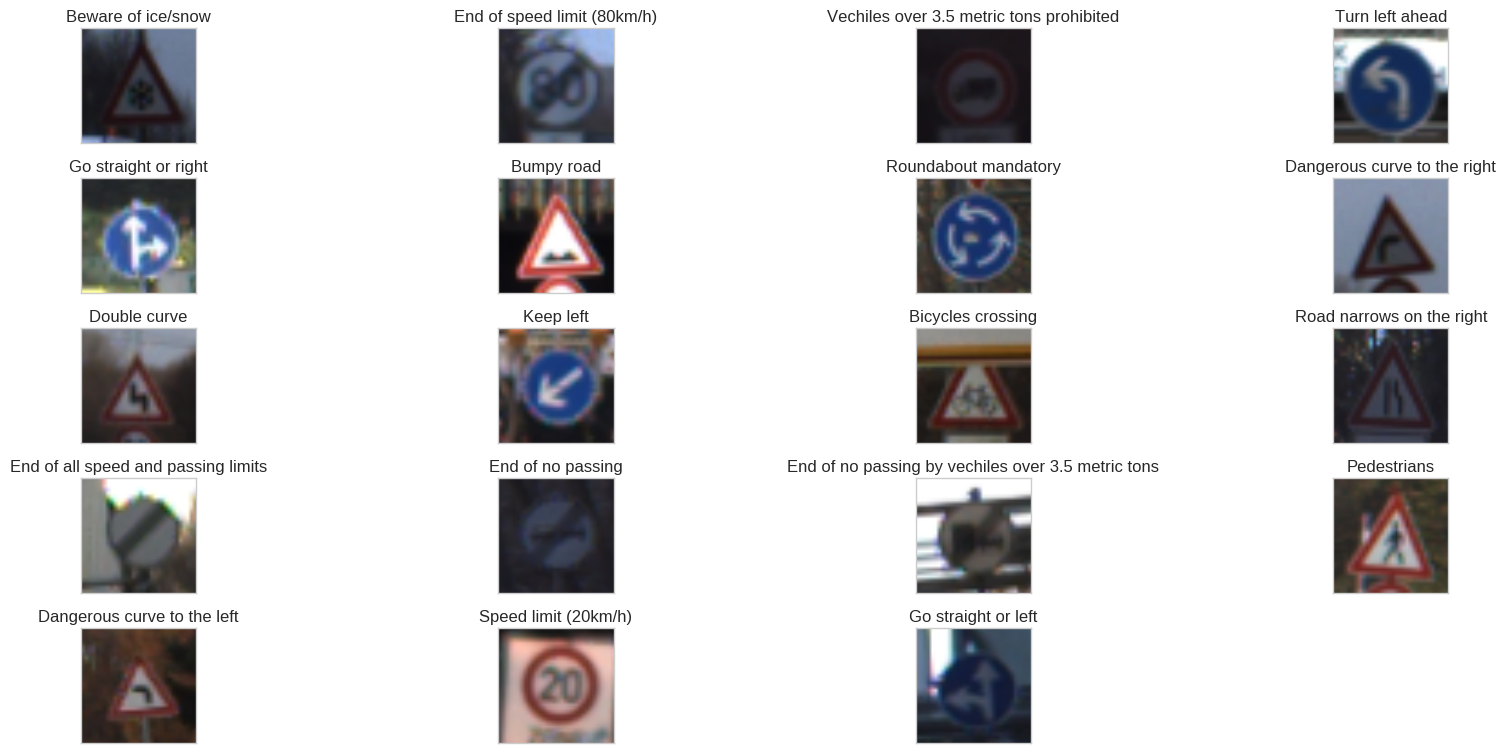

In [5]:
gs2 = gridspec.GridSpec(5, 4, top=1., bottom=-0.3, right=2.0, left=0., hspace=0.3, wspace=0.2)
i=0

# Get indexes of each example type we're going to visualize
for signtype in datacount[24:43].index:
    indexes = traindata[traindata["SignName"]==signtype].index.tolist()
   
    bx=plt.subplot(gs2[i])
    bx.imshow(X_train[indexes[100]])
    bx.set_xticks([])
    bx.set_yticks([])
    bx.set_title(signtype)
    i+=1

The two cells above show a selection of signs present in the dataset. It is clear from the dataset that these signs were captured in different data lightening conditions. So it means we need to process that data before forwarding it to the CNN.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Here we complete the preprocessing step. In this step I have processed the images through the CLAHE based RGB normaization step. Which lightens the images and clearly enhances different features present in the imges.

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

To process my images I am applying the CLAHE Algorithm in the LAB color space to do the contrast enhancement. The results of this enhancement can be seen in the images generated in the previous step. 

In addition to the contrast enhancement I am normalizing the images between [0..1] by dividing the image data by the max in that image. 

Intially tried the grayscale based single layer processing it was faster and layers were quick to reach a good accuracy. It was also reported by the Yan  Lecun that they were able to achieve better accuracy with grayscale images for traffic sign classification. 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
(235254, 32, 32, 3) (235254,)


(0, 15000)

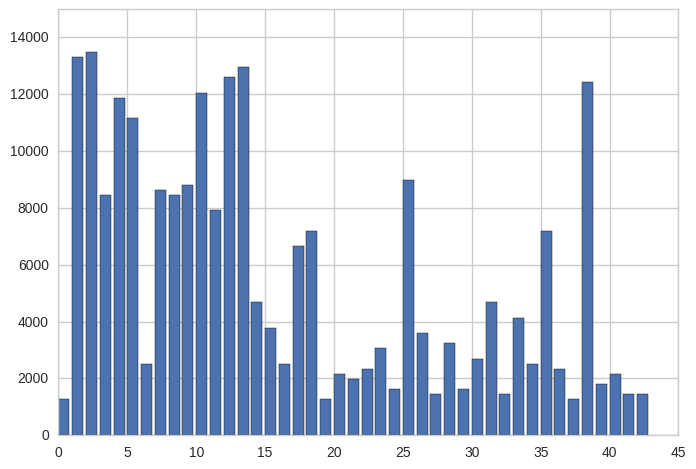

In [6]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle
import scipy
from scipy import linalg
import scipy.ndimage as ndi
from skimage import transform, exposure
from skimage.util import random_noise
import skimage

#X_train=train_x
#X_test=test_x

# Following few functions are taken form the tflearn library code. 
# http://tflearn.org/data_augmentation/#image-augmentation


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix



def apply_transform(x, transform_matrix, channel_index=2, fill_mode='nearest', cval=0.):
    x = np.rollaxis(x, channel_index, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,
                      final_offset, order=0, mode=fill_mode, cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x

def shear(x, intensity=0.3, is_random=False, row_index=0, col_index=1, channel_index=2, fill_mode='nearest', cval=0.):
    if is_random:
        shear = np.random.uniform(-intensity, intensity)
    else:
        shear = intensity
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])

    h, w = x[0].shape[row_index], x[0].shape[col_index]
    transform_matrix = transform_matrix_offset_center(shear_matrix, h, w)
    results = []
    for data in x:
        results.append( apply_transform(data, transform_matrix, channel_index, fill_mode, cval))
    return np.asarray(results)

def shift(x, wrg=0.2, hrg=0.2, is_random=False, row_index=0, col_index=1, channel_index=2,
                 fill_mode='nearest', cval=0.):
    h, w = x[0].shape[row_index], x[0].shape[col_index]
    if is_random:
        tx = np.random.uniform(-hrg, hrg) * h
        ty = np.random.uniform(-wrg, wrg) * w
    else:
        tx, ty = hrg * h, wrg * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

    transform_matrix = translation_matrix  # no need to do offset
    results = []
    for data in x:
        results.append( apply_transform(data, transform_matrix, channel_index, fill_mode, cval))
    return np.asarray(results)

def rotation(x, rg=10, is_random=False, row_index=0, col_index=1, channel_index=2,
                    fill_mode='nearest', cval=0.):
    if is_random:
        theta = np.pi / 180 * np.random.uniform(-rg, rg)
    else:
        theta = np.pi /180 * rg
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

    h, w = x[0].shape[row_index], x[0].shape[col_index]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    results = []
    for data in x:
        results.append( apply_transform(data, transform_matrix, channel_index, fill_mode, cval))
    return np.asarray(results)

def multitransform(x):
    x=rotation(x, is_random=True)
    x=shift(x, is_random=True)
    x=shear(x, is_random=True)
    return x

def randomly_distort(x,y):
    for i in range(43):
        print(i)
        indexes = y == i
        #count = np.sum(indexes)
        ex= 5 #int(2200/count)
        x_train_sample = x[indexes]
        y_train_sample = y[indexes]
        x_extra = []
        y_extra = []
        for i in range(ex):
            x_extra = multitransform(x_train_sample)
            x = np.concatenate((x, x_extra))
            y = np.concatenate((y, y_train_sample))
    return x,y
    
X_train, y_train = randomly_distort(X_train, y_train)
       
        

print(X_train.shape, y_train.shape)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train)

# Plotting number of samples v/s sign id
counts = []
for i in range(43):
    counts.append(np.sum(y_train == i))

count_plot = plt.bar(range(43),counts)
axes = plt.gca()
axes.set_ylim([0,15000])


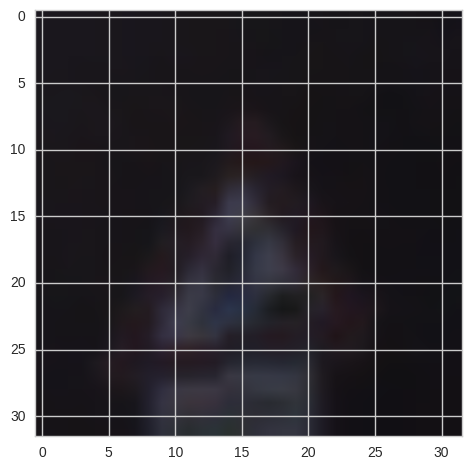

In [7]:
## Show the above samples with preprocessing applied
#for X in traindata.iterrows():
plt.figure()

plt.imshow(X_train[204500])


[[[ 1.          0.99215686  1.        ]
  [ 0.9372549   0.92156863  0.95686275]
  [ 0.9372549   0.92156863  0.95686275]
  ..., 
  [ 0.82352941  0.80392157  0.81568627]
  [ 0.72941176  0.71372549  0.74901961]
  [ 0.79215686  0.78039216  0.81960784]]

 [[ 1.          0.99215686  1.        ]
  [ 0.9372549   0.92156863  0.95686275]
  [ 0.9372549   0.92156863  0.95686275]
  ..., 
  [ 0.89019608  0.86666667  0.90196078]
  [ 0.79215686  0.78039216  0.81960784]
  [ 0.86666667  0.85098039  0.88627451]]

 [[ 1.          0.99215686  1.        ]
  [ 0.9372549   0.92156863  0.95686275]
  [ 0.9372549   0.92156863  0.95686275]
  ..., 
  [ 0.96078431  0.9372549   0.97254902]
  [ 0.86666667  0.85098039  0.88627451]
  [ 1.          0.99607843  1.        ]]

 ..., 
 [[ 0.94509804  0.9254902   0.9372549 ]
  [ 0.8745098   0.85098039  0.88235294]
  [ 0.94509804  0.92156863  0.95294118]
  ..., 
  [ 0.96078431  0.94509804  0.96470588]
  [ 0.97254902  0.96078431  0.97647059]
  [ 0.97254902  0.96078431  0.97647

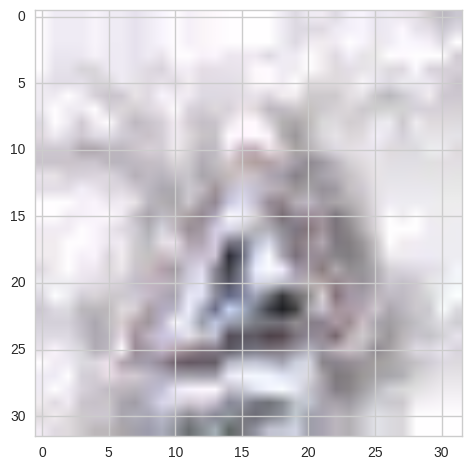

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2
from sklearn.preprocessing import scale

def preprocess(image):
    image=cv2.convertScaleAbs(image)

    # Convert to LAB colorspace
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    
    limg = cv2.merge((cl,a,b))
    
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    final=final/final.max()

    return final

ft=preprocess(X_train[204500])
plt.figure()

plt.imshow(ft)
print(ft)

print("Preprocessing done.")

In [9]:
# Construct the preprocessed x data
train_x = np.array([preprocess(image) for image in X_train], dtype=np.float32)
test_x = np.array([preprocess(image) for image in X_test], dtype=np.float32)

X_train=train_x
X_test=test_x


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I've decided to generate augmented data through three mechanisms by adding the following trasnformations.
1. Rotation (-10 , 10 )
2. Shifting (-5 , 5 )
3. Shearing (-5 , 5 )

Then for each image, I generate 5 additional images with 5 by randomly rotating, shifting and shearing it. 

Then this augmented is processed through our processing algorithm for training. 


## Model No:1

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten




def model(x, dropout):
    #Hyperparameters
    mu=0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x100.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 100), mean = mu, stddev = sigma),name="w0" )
    conv1_b = tf.Variable(tf.zeros(100),name="b0")
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.elu(conv1)
    
    
    # SOLUTION: Pooling. Input = 30x30x100. Output = 15x15x100.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #conv1 = tf.nn.dropout(conv1, 0.75)
    
    # SOLUTION: Layer 2: Convolutional. Output = 13x13x150.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 100, 150), mean = mu, stddev = sigma),name="w1")
    conv2_b = tf.Variable(tf.zeros(150),name="b1")
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.elu(conv2)

    # SOLUTION: Pooling. Input = 13x13x150. Output = 7x7x150.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #conv2 = tf.nn.dropout(conv2, 0.75)
    # SOLUTION: Flatten. Input = 7x7x150. Output = 400.
    
    # SOLUTION: Layer 3: Convolutional.Input = 7x7x150 Output = 4x4x250.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 150, 250), mean = mu, stddev = sigma), name="w2")
    conv3_b = tf.Variable(tf.zeros(250),name="b2")
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # SOLUTION: Activation.
    conv3 = tf.nn.elu(conv3)

    # SOLUTION: Pooling. Input = 4x4x150. Output = 2x2x250.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #conv2 = tf.nn.dropout(conv2, 0.75)
    
    
    # SOLUTION: Flatten. Input = 2x2x250. Output = 1000.
    fc0   = flatten(conv3)
    
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1000, 500), mean = mu, stddev = sigma),name="w3")
    fc1_b = tf.Variable(tf.zeros(500),name="b3")
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.elu(fc1)
    #fc1 = tf.nn.dropout(fc1, 0.75)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(500, 172), mean = mu, stddev = sigma),name="w4")
    fc2_b  = tf.Variable(tf.zeros(172),name="b4")
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.elu(fc2)
    #fc2 = tf.nn.dropout(fc2, dropout)
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(172, 43), mean = mu, stddev = sigma),name="w5")
    fc3_b  = tf.Variable(tf.zeros(43),name="b5")
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits



### Model No:2

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten





def model(x, keepprob):
    #Hyperparameters
    mu=0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x100.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 100), mean = mu, stddev = sigma),name="w0")
    conv1_b = tf.Variable(tf.zeros(100),name="b0")
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.elu(conv1)
    
    
    # SOLUTION: Pooling. Input = 30x30x100. Output = 15x15x100.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #conv1 = tf.nn.dropout(conv1, 0.75)
    
    # SOLUTION: Layer 2: Convolutional. Output = 13x13x150.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 100, 150), mean = mu, stddev = sigma),name="w1")
    conv2_b = tf.Variable(tf.zeros(150),name="b1")
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.elu(conv2)

    # SOLUTION: Pooling. Input = 13x13x150. Output = 7x7x150.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #conv2 = tf.nn.dropout(conv2, 0.75)
    # SOLUTION: Flatten. Input = 7x7x150. Output = 400.
    
    # SOLUTION: Layer 3: Convolutional.Input = 7x7x150 Output = 4x4x250.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 150, 250), mean = mu, stddev = sigma),name="w2")
    conv3_b = tf.Variable(tf.zeros(250),name="b2")
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # SOLUTION: Activation.
    conv3 = tf.nn.elu(conv3)

    # SOLUTION: Pooling. Input = 4x4x150. Output = 2x2x250.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #conv2 = tf.nn.dropout(conv2, 0.75)
    
    
    # SOLUTION: Flatten. Input = 2x2x250. Output = 1000.
    fc_c1 = flatten(conv1)
    fc_c2 = flatten(conv2)
    fc_c3 = flatten(conv3)
    
    #print( fc_c2.get_shape() )
    #print( fc_c3.get_shape() )
    
    fc0   = tf.concat(1, [fc_c1, fc_c2, fc_c3])
    #print( fc0.get_shape() )
    
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 500.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc0.get_shape().as_list()[-1], 500), mean = mu, stddev = sigma),name="w3")
    fc1_b = tf.Variable(tf.zeros(500),name="b3")
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.elu(fc1)
    #fc1 = tf.nn.dropout(fc1, keepprob)

    # SOLUTION: Layer 4: Fully Connected. Input = 500. Output = 172.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(500, 172), mean = mu, stddev = sigma),name="w4")
    fc2_b  = tf.Variable(tf.zeros(172),name="b4")
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.elu(fc2)
    #fc2 = tf.nn.dropout(fc2, keepprob)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 172. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(172, 43), mean = mu, stddev = sigma),name="w5")
    fc3_b  = tf.Variable(tf.zeros(43),name="b5")
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**


I have utilized multiple models (models 1 and model 2) which are shown in the cells above. I have used a traditional mnist style lenet model with some additional convolutional layers and Fully connected layers as shown below. In the second model, I have additionally flattened and concatenated the convolutional layers outputs before passing it to FC layer.

#### Model 1
1. Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x100. Activation = elu. Pooling. Input = 30x30x100. Output = 15x15x100. Filter size : [3x3x100]
    
2. Layer 2: Convolutional. Output = 13x13x150. SOLUTION: Activation=elu. Pooling. Input = 13x13x150. Output = 7x7x150. [3x3x150]
3. Layer 3: Convolutional.Input = 7x7x150 Output = 4x4x250. Activation=elu. Pooling. Input = 4x4x150. Output = 2x2x250. [3x3x250]

4. Layer 4: Flatten. Input = 2x2x250. Output = 1000. Activation=elu. 

5. Layer 5: Fully Connected. Input = 1000. Output = 500. Activation=elu. 

6. Layer 6: Fully Connected. Input = 500. Output = 172. Activation=elu.

7. Layer 7: Fully Connected. Input = 172. Output = 43.


#### Model 2
1. Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x100. Activation = elu. Pooling. Input = 30x30x100. Output = 15x15x100. Filter size : [3x3x100]
    
2. Layer 2: Convolutional. Output = 13x13x150. SOLUTION: Activation=elu. Pooling. Input = 13x13x150. Output = 7x7x150. [3x3x150]
3. Layer 3: Convolutional.Input = 7x7x150 Output = 4x4x250. Activation=elu. Pooling. Input = 4x4x150. Output = 2x2x250. [3x3x250]

4. Layer 4: Flattened and concatenated  conv1, conv2 and conv3 layers. Input = 2x2x250. Output = 1000. Activation=elu. 

5. Layer 5: Fully Connected. Input = 1000. Output = 500. Activation=elu. 

6. Layer 6: Fully Connected. Input = 500. Output = 172. Activation=elu.

7. Layer 7: Fully Connected. Input = 172. Output = 43.





In [12]:
# Important note - Restoring the saved model only works after restarting the jupyter notebook kernel

### Train your model here.
### Feel free to use as many code cells as needed.


#BATCH_SIZE =64
#BATCH_SIZE =128
BATCH_SIZE =256
EPOCHS = 25
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

rate = 0.0001

logits = model(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data, dropout):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


    

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_trainb, X_validb, y_trainb, y_validb  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        num_examples = len(X_trainb)
        #X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_trainb[offset:end], y_trainb[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
            
        validation_accuracy = evaluate(X_validb, y_validb, 1.)
        print("EPOCH {} ...".format(i+1)),
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        #test_accuracy = evaluate(X_test, y_test, 1.)
        #print("Test Accuracy = {:.3f}".format(test_accuracy))
        print()
    test_accuracy = evaluate(X_test, y_test, 1.)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
        
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, './checkpoints/trafficsigns.ckpt')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.783

EPOCH 2 ...
Validation Accuracy = 0.915

EPOCH 3 ...
Validation Accuracy = 0.948

EPOCH 4 ...
Validation Accuracy = 0.967

EPOCH 5 ...
Validation Accuracy = 0.976

EPOCH 6 ...
Validation Accuracy = 0.981

EPOCH 7 ...
Validation Accuracy = 0.984

EPOCH 8 ...
Validation Accuracy = 0.986

EPOCH 9 ...
Validation Accuracy = 0.988

EPOCH 10 ...
Validation Accuracy = 0.987

EPOCH 11 ...
Validation Accuracy = 0.990

EPOCH 12 ...
Validation Accuracy = 0.990

EPOCH 13 ...
Validation Accuracy = 0.990

EPOCH 14 ...
Validation Accuracy = 0.992

EPOCH 15 ...
Validation Accuracy = 0.994

EPOCH 16 ...
Validation Accuracy = 0.991

EPOCH 17 ...
Validation Accuracy = 0.995

EPOCH 18 ...
Validation Accuracy = 0.995

EPOCH 19 ...
Validation Accuracy = 0.995

EPOCH 20 ...
Validation Accuracy = 0.995

EPOCH 21 ...
Validation Accuracy = 0.995

EPOCH 22 ...
Validation Accuracy = 0.995

EPOCH 23 ...
Validation Accuracy = 0.995

EPOCH 24 ...
Validation Accura

In [14]:
# Do a final test
#print(len(y_test))

#saver=tf.train.Saver()    
with tf.Session() as sess:
    loader = tf.train.import_meta_graph("./checkpoints/trafficsigns.ckpt.meta")
    loader.restore(sess, tf.train.latest_checkpoint("./checkpoints/"))
    
    test_accuracy = evaluate(X_test, y_test, 1.)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    

Test Accuracy = 0.945


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
Kepping in view the recommendations of Yoshua Bengio in his article titled "Practical Recommendations for Gradient-Based Training of Deep Architectures". He recommends following for epoch and batch sizes:


1. Initial Learning Rate : I have kept the rate around 0.001. I did experiments with the additional values and I found this value to be good enough. This is often the single most important hyperparameter and one should always make sure that it has been tuned. According to Y. bengio as written in his article the typical values for a neural network with standardized inputs (or inputs mapped to the (0,1) interval) are less than 1 and greater than 10E−6 but these should not be taken as strict.

2. Batch Size: The mini-batch size is typically chosen between 1 and a few hundreds and I have chosen it to be 256 although I experimented with other values too. The impact of batch size is always on the number of computations as mentioned by Y. Bengio, larger batch size yield faster computation but requires visiting more examples in order to reach the same error, since there are less updates per epoch. This hyper-parameter will only impact training time and not so much test performance, so it can be optimized separately of the other hyperparameters.

3. Epochs : Choosen by me to be 25 because I am doing computations locally and I was unable to run it for long times. I also got good results with 50 epochs while 100 epochs was an overkill. I initially started with the 100 epochs but I quickly found out thay my algorithm converged quickly and it required less number of the epcohs to complete it. Hence I reduced the value by half and finally to the figure of 25. This hyperparameter requires that we keep a close watch on the results we get. If we prefer early stopping then this parameter can help us avoid over fitting. Practically, if somebody reaches a small values then we should wait and if the error does not reduce after a certain number of epochs then we stop the training.

4. Optimization Algorithm: I have choosen to use the adam optmizier built into the tensorflow. It is one of the newest additons in terms of an optimizer and people have reported achieving good results with this algorithm. I have also tried RMSProp, Adagrad etc. I found out that Adam was better and it converged quickly to the minimum.


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
### Stage 1:
Initially I started with letnet model which we learned in the class and is starting point in dep learning litrature. I preprocessed the images and converted them to the grayscale and contrast enhanced the images to get better accuracy. Then I passed the data to the lenet classifier which gave me quite a good result. 

### Stage 2:
But to enhance my learning I then modified the model to use all three layers which basically added some complexity to the system. I have also added the augmented data and that augmentation increased the accuracy of the system a lot. Also I modified the preprocessing algorithm so that it now worked with the RGB images.

### Stage 3:
Encouraged by the results I have got in the last stage I modified my layer configuration by adding more layers.

### Stage 4:
In stage I epxerimented with the dropout layers but was unable to secure good results with it.

### Stage 5:
To further enhance the results I tried to emulate the model which was used by the yann Lecun in his seminal paper on the traffic sign classification. In that I concatenated the results of the three conv layers after flattening them. This enhanced my models results a bit further.





---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

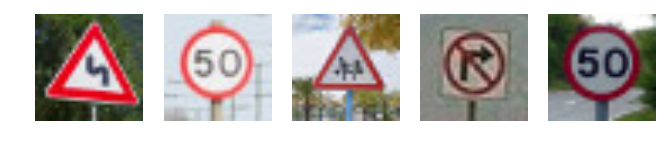

In [15]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg

directory = 'testsigns/'

test_images = np.zeros((5,32,32,3)) #, dtype=np.uint8)

for i in range(5):
    image = mpimg.imread(directory + "image%d.jpg" % (i+1) )
    test_images[i] = preprocess(image)
    plt.subplot(1, 5, i+1)
    plt.imshow(image.astype('uint8'))
    plt.axis('off')
    
test_images = test_images.astype(np.float32)
#test_images = preprocess(test_images)
test_images = test_images.astype(np.float32)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
I have selected the images shown above as my candidate images. These images are not that difficult to analyze but they provide a different point of view of the similar type of images in the dataset. The  traffic sign images here are taken closely which makes it difficult for the classifier to easily identify the images.
Also I have included some images which are not into the dataset to checl the capability of the system.

[21  2 29  1  5]
Predictions are:


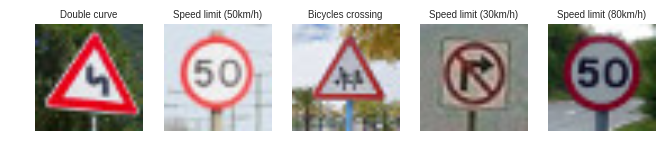

In [16]:

### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    loader = tf.train.import_meta_graph("./checkpoints//trafficsigns.ckpt.meta")
    loader.restore(sess, tf.train.latest_checkpoint('./checkpoints/'))
    predicted_logits = sess.run(logits, feed_dict={x:test_images, keep_prob:1})

predicted_labels = np.argmax(predicted_logits, axis=1)
print(predicted_labels)
print("Predictions are:")

for i in range(5):
    image = mpimg.imread(directory + "image%d.jpg" % (i+1) )
    plt.subplot(1, 5, i+1)
    plt.title(signnames["SignName"][predicted_labels[i]], fontsize=7)
    plt.imshow(image.astype('uint8'))
    plt.axis('off')
    

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_

**Answer:**

1. Correct : First sign is identfied correctly as it is in the dataset.
2. Correct: Second sign is also identified Correclty.
3. Incorrect: This image is also similar to the bicycle crossign images that is why it confuses the classifier.
4. Incorrect: This class is not present in the dataset so it was supposed to be wrong. I liked to observe the generalization capability of the network.
5. Incorrect: The reason seems simple the 50 KM/h speed limit is very similar in apperance to another class(80 km/h limit)

The system was only able to achieve 40% accuracy on my given data, while it performed very well for the GTSRB test dataset. 
This was to be expected as the system was only able to recognize sign for which it as trained. We can still improve by creating seaparate training datasets for different countries.



Double curve , Right-of-way at the next intersection , Pedestrians , Stop , Road work
Speed limit (50km/h) , Speed limit (80km/h) , Speed limit (20km/h) , Speed limit (30km/h) , Speed limit (100km/h)
Bicycles crossing , Wild animals crossing , Bumpy road , Dangerous curve to the left , Slippery road
Speed limit (30km/h) , Speed limit (20km/h) , Stop , Speed limit (60km/h) , Speed limit (80km/h)
Speed limit (80km/h) , Speed limit (50km/h) , Right-of-way at the next intersection , Speed limit (30km/h) , Speed limit (20km/h)


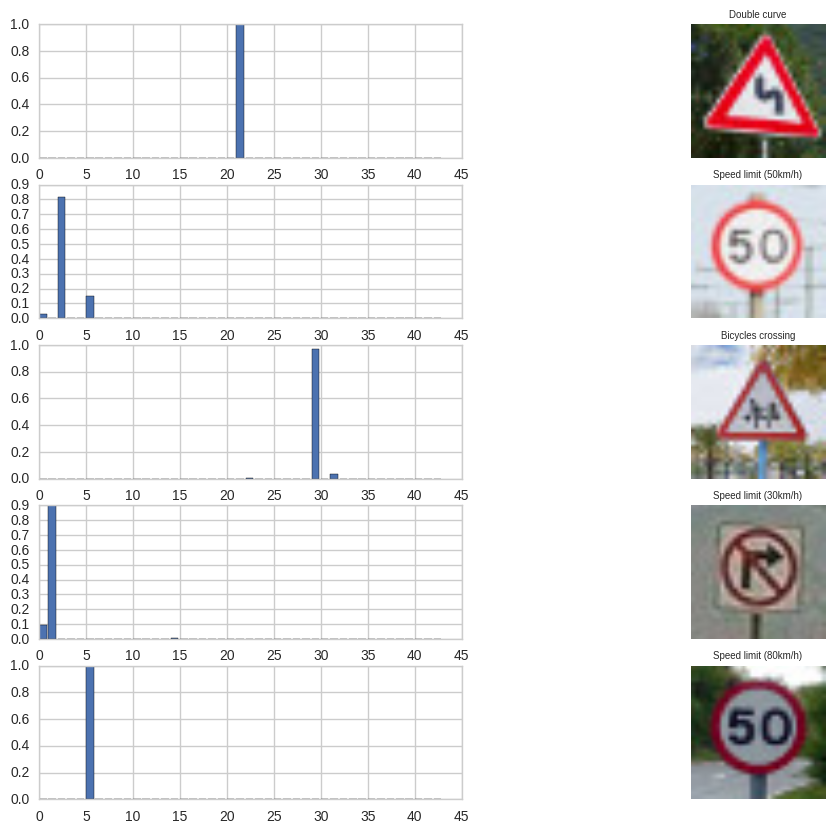

In [19]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import seaborn as sns
sns.set_style("whitegrid")
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)


softmax_probabilites = softmax(predicted_logits)
v,inp = tf.nn.top_k(predicted_logits, k=43)
sess=tf.InteractiveSession()
#print(sess.run(inp))
#print(sess.run(v))
iev = inp.eval()
vev = softmax(v.eval())

for i in range(5):
    print(signnames["SignName"][ iev[i][0] ],',', signnames["SignName"][ iev[i][1] ], ',',
          signnames["SignName"][ iev[i][2] ], ',', signnames["SignName"][ iev[i][3]], ',', 
          signnames["SignName"][ iev[i][4] ] )  

fig = plt.figure(figsize=(12, 10))
width = 1.5
x_vals = range(43)

#print(vev[0][:])
k=0
for i in range(5):
    image = mpimg.imread(directory + "image%d.jpg" % (i+1) )
    k=k+1
    ax = fig.add_subplot(5,2,k)
    ax.bar(iev[i][:], vev[i][:])
    
    k=k+1
    plt.subplot(5, 2, k)
    plt.title(signnames["SignName"][predicted_labels[i]], fontsize=7)
    plt.imshow(image.astype('uint8'))
    plt.axis('off')
    

plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**



#### Good Generalization
1. By looking at the results for the top 5 predictions in the graphs generated in previous cells we can see that systems was precise enough to generaly find the signs even if not in the first try. 

2. Even if the system was unable to predict the signs correctly 60 percent of the times, it was generally able to predict the correct class in top 5 predictions.

3. The sign four of no right turn was not present in the dataset so it was not correctly found. This is more likely the deficincy of the datset rather the capability of the algorithm.

4. By looking at the top predictions in the graphs in previous cells we can observe that most of the time the system is sure about its predictions. Even in the fourth case which is not present in the dataset. This needs to be explored further.

5. Another observation which I gathered personally from the data is that most of the time the error is generated in the speed limit signs as those signs are similar in strucuture and color combinations. If we can combine the speed limits into a separate class and combine it and process in a separate CNN then we can get better results. **I need to explore this further in future.**

6. Children crossing sign is also confusing enough as it is similar to the bicycle crossing sign. This also confuses the system 

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

The interface is very simple. The model is stored in the checkpoint files and latest model can be loaded whenever it is needed. The steps to process the new image are written below:

1. Loading of the new image into an array of 32x32x3 through your favourite library.
2. Preprocessing of the new image through preprocess() function. This function requires a single argument of type 32x32x3. 
3. To classify the image we need to  create a new session and pass the image to the logits function. This function classifies the image and returns the class id of the class with highest confidence.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## 